In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

import re
import numpy as np

import helper_functions

import numpy as np
import pandas as pd

In [3]:
%run settings/plt_settings.ipynb

In [4]:
_all_valid_AA_code = "RKDEQNHSTYCMWAILFVPG"
_invalid_AA_regex = "[^%s]" % _all_valid_AA_code #negacija svih validnih

assert( len(_all_valid_AA_code) == 20 )

def AA_is_valid(seq, invalid_regex=None):
    ''' Return True if no invalid AA code can be found ''' 
    return not re.search(invalid_regex or _invalid_AA_regex, seq)

def AA_show_invalid(seq, invalid_regex=None):
    ''' Return Counter object showing all iregularites '''
    return Counter(re.findall(invallid_regex or _invalid_AA_regex, seq))



###  Ucitavamo proteine

In [5]:
all_proteins = [r for r in SeqIO.parse("data/IN/CAFA3_training_data/uniprot_sprot_exp.fasta", "fasta")]
print("ukupno originalnih proteina:", len(all_proteins))

ukupno originalnih proteina: 66841


In [6]:
all_valid_proteins = [r for r in all_proteins 
                            if AA_is_valid(str(r.seq)) and len(r.seq)>=9] #minimum 9 jer vsl2b ne podrzva manje

print("ukupno validnih proteina:", len(all_valid_proteins))
print("validnih >=40AK:", sum( len(r.seq)>40 for r in all_valid_proteins ) )

ukupno validnih proteina: 66599
validnih >=40AK: 66063


###  Cuvamo validne proteine u valid_proteins.fasta

### Random i Uniform modele 

In [7]:
def AAfequency(records):
    """generate a dict that represents a free variable for AA code
       based on AA sequence in fasta file 
    """
    from collections import Counter
    c = Counter()
    N = 0 # ukupna duzina svih proteina
    for record in records:
        c.update(record.seq)
        N += len(record.seq) 

    return { ak: k/N   for ak, k in c.items()}

AAfreq = AAfequency(all_valid_proteins)

### Crtamo AK ucestalosti

In [8]:
ak_info = pd.read_csv('data/ak_info', sep=' ', escapechar='\\' )

AAfreq_df=pd.DataFrame.from_dict(AAfreq, orient='index', )
AAfreq_df.columns = ['p']
ak_info = ak_info.merge(AAfreq_df, left_on='id', right_index=True)

ak_info.head()

,id,id3,name,avg,exact,duno,p
0,G,Gly,Glycine,75.07,75.03,57,0.064621
1,A,Ala,Alanine,89.10,89.05,71,0.071057
2,S,Ser,Serine,105.09,105.04,87,0.081890
3,P,Pro,Proline,115.13,115.05,97,0.055120
4,V,Val,Valine,117.15,117.08,99,0.062784


In [9]:
disorder_promoting = "GASPQKER"
order_promoting = "VCILNFW"

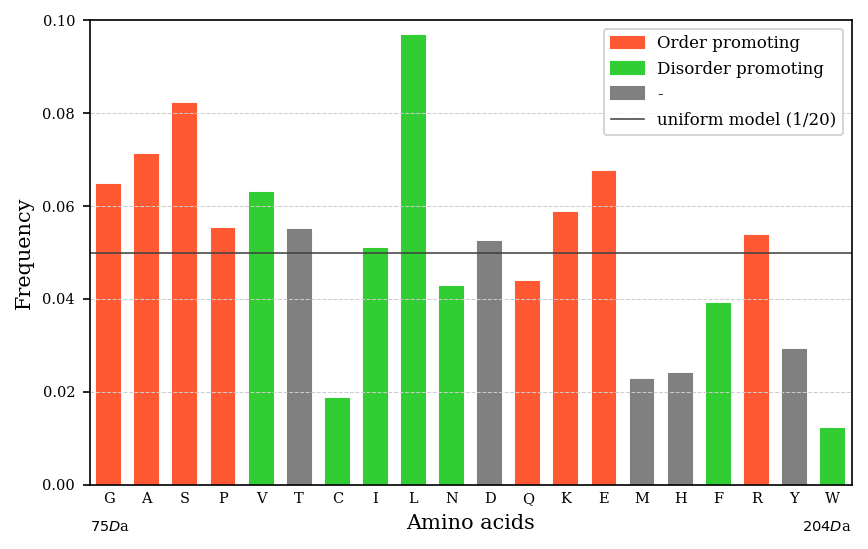

In [12]:
fig, ax = plt.subplots() 

color_red = (1,0.35,0.2)
color_green = 'limegreen'
color_gray = "0.5"

bars = ax.bar(ak_info.index, ak_info.p, 0.6)

_ = plt.xticks(ak_info.index, ak_info.id)
plt.tick_params(which='major', axis='x', length=0)


for bar, ak in zip(bars, ak_info.id):
    bar.set_color( ak in disorder_promoting and color_red or
                   ak in order_promoting    and color_green or color_gray)

ax.set_xlim(-.5, 19.5)
ax.set_ylim(0, 0.1)
ax.set_yticks( np.linspace(0, 0.1, 6))
ax.grid(which='major', axis='x')

line, = ax.plot((-1,20), (1/20, 1/20), c='0.25', lw=0.75, label='uniform model (1/20)') 

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color=color_red, label='Order promoting')
green_patch = mpatches.Patch(color=color_green, label='Disorder promoting')
gay_patch = mpatches.Patch(color=color_gray, label='-')


#ax.set_title("Učestalost aminokiselina u podacima")
ax.set_xlabel("Amino acids")
ax.set_ylabel("Frequency")


ax.text(-0.5, -0.010, '$%dD$a'%ak_info.iloc[0].avg, fontsize=7, )
ax.text(19.5, -0.010, '$%dD$a'%ak_info.iloc[-1].avg, fontsize=7, ha="right")
ax.legend(handles=[red_patch, green_patch, gay_patch, line], fontsize=8)

plt.tight_layout(pad=0)
plt.savefig("plots/dataset/AK_ucestalost.png")

#  generisemo random i uniformne varijante i cuvamo u fajl

Ovo radimo samo jedanput na pocetku

In [8]:
def makeRandomRecord(org_record, model):
    return SeqRecord( Seq( model(len(org_record.seq)), IUPAC.protein)
                      , id=org_record.id, name=org_record.name, description="" )